# **Notebook 2a**: YOLOv8

<span style="font-size: 1.5rem;">By **Melat Assefa**</span>

## Section 0: Notebook Metadata and Configuration

## Reproducability

In [1]:
SEED = 3129
NUM_CLASSES = 6

EPOCHS = 15
BATCH_SIZE = 16
IMAGE_SIZE = 416
LEARNING_RATE = 0.001

HSV_H = 0.015
HSV_S = 0.7
HSV_V = 0.4

DATA_ROOT = "dataset/YOLO_COCO"
DATA_YAML_JSON = f"{DATA_ROOT}/data.yaml.json"
DATA_YAML = f"{DATA_ROOT}/data.yaml"

TRAIN_IMG = f"{DATA_ROOT}/images/train"
VAL_IMG = f"{DATA_ROOT}/images/val"
TEST_IMG = f"{DATA_ROOT}/images/test"

TRAIN_LAB = f"{DATA_ROOT}/labels/train"
VAL_LAB = f"{DATA_ROOT}/labels/val"
TEST_LAB = f"{DATA_ROOT}/labels/test"

OUTPUT_DIR = "work_dirs/yolov8_sign_type"

CLASS_NAMES = [
    "Blind-Spot Mirror (Convex)",
    "No Entry (One Way)",
    "No Through Road (T-Sign)",
    "Pedestrian Crossing",
    "Roundabout Ahead",
    "Stop"
]

## Section 1: Environment setup(Pytorch + Ultralytics)

In [2]:
import os, sys, time, json, random, glob
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import time
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import ultralytics
from ultralytics import YOLO

print("Environment Information")
print(f"Python version: {sys.version.split()[0]}")
print(f"Pytorch version: {torch.__version__}")
print(f"CUDA availble: {torch.cuda.is_available()}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def set_seed(seed):
    os.environ["PYTHONHASHSEEN"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

print(f"\nRandom seed set to: {SEED}")

REPO_ROOT = Path.cwd()
DATA_DIR = REPO_ROOT / "dataset" / "YOLO_COCO"
OUT_DIR = REPO_ROOT / "work_dirs" / "yolov8_sign_type"

print("\nPATH CHECKS")
print("REPO_ROOT:", REPO_ROOT)
print("DATA_DIR:", DATA_DIR)
print("OUT_DIR:", OUT_DIR)

assert REPO_ROOT.exists(), "REPO_ROOT does not exist"
assert DATA_DIR.exists(), "DATA_DIR does not exist"

OUT_DIR.mkdir(parents=True, exist_ok=True)
print("n\Output directory exists:", OUT_DIR)


Environment Information
Python version: 3.10.19
Pytorch version: 2.4.1
CUDA availble: False
Using device: cpu

Random seed set to: 3129

PATH CHECKS
REPO_ROOT: c:\ARI3129-repo
DATA_DIR: c:\ARI3129-repo\dataset\YOLO_COCO
OUT_DIR: c:\ARI3129-repo\work_dirs\yolov8_sign_type
n\Output directory exists: c:\ARI3129-repo\work_dirs\yolov8_sign_type


## Section 2: Datset Validation

In [3]:
from collections import Counter

IMG_EXTS = {".jpg", ".jpeg", ".png"}

def list_images(img_dir: Path):
    return sorted([p for p in img_dir.iterdir() if p.suffix.lower() in IMG_EXTS])

def list_labels(lbl_dir: Path):
    return sorted([p for p in lbl_dir.iterdir() if p.suffix.lower() == ".txt"])

def stem_set(paths):
    return {p.stem for p in paths}

def validate_split(split: str):
    img_dir = DATA_DIR / "images" / split
    lbl_dir = DATA_DIR / "labels" / split
    
    assert img_dir.exists(), f"Missing image dir: {img_dir}"
    assert lbl_dir.exists(), f"Missing label dir: {lbl_dir}"

    imgs = list_images(img_dir)
    lbls = list_labels(lbl_dir)

    img_stems = stem_set(imgs)
    lbl_stems = stem_set(lbls)

    missing_imgs = sorted(list(lbl_stems - img_stems))
    missing_lbls = sorted(list(img_stems - lbl_stems))

    print(f"\n[{split.upper()}]")
    print("Images:", len(imgs))
    print("Labels:", len(lbls))
    print("Labels without image:", len(missing_imgs))
    print("Images without label:", len(missing_lbls))

    # missing images check
    if missing_imgs[:5]:
        print("Example labels missing images:", missing_imgs[:5])
    if missing_lbls[:5]:
        print("Example images missing labels:", missing_lbls[:5])

    return img_dir, lbl_dir, imgs, lbls, missing_imgs, missing_lbls

splits = ["train", "val", "test"]
split_data = {s: validate_split(s) for s in splits}



[TRAIN]
Images: 483
Labels: 483
Labels without image: 0
Images without label: 0

[VAL]
Images: 88
Labels: 88
Labels without image: 0
Images without label: 0

[TEST]
Images: 86
Labels: 86
Labels without image: 0
Images without label: 0


In [4]:
def parse_label_line(line: str):
    parts = line.strip().split()
    if len(parts) != 5:
        return None, "Line does not have 5 elements"
    try:
        cls = int(float(parts[0]))
        x, y, w, h = map(float, parts[1:])
    except Exception:
        return None, "Could not parse numbers"
    return (cls, x, y, w, h), None

def validate_labels(lbl_paths, num_classes: int):
    bad_files = []
    cls_counter = Counter()

    for lp in lbl_paths:
        text = lp.read_text(encoding="utf-8", errors="ignore").strip()
        if text == "":
            continue
        
        for i, line in enumerate(text.splitlines(), start=1):
            parsed, err = parse_label_line(line)
            if err:
                bad_files.append((lp, i, err, line))
                continue

            cls, x, y, w, h = parsed
            cls_counter[cls] += 1

            if not (0 <= cls < num_classes):
                bad_files.append((lp, i, f"class_id {cls} out of range", line))
            for name, v in [("x", x), ("y", y), ("w", w), ("h", h)]:
                if not (0.0 <= v <= 1.0):
                    bad_files.append((lp, i, f"{name}={v} not in [0,1]", line))

    print("\nLABEL CHECK SUMMARY")
    print("Total bad entries:", len(bad_files))
    if bad_files[:5]:
        print("\nExamples (up to 5):")
        for bf in bad_files[:5]:
            print("File:", bf[0])
            print(" Line:", bf[1], "| Issue:", bf[2])
            print(" Text:", bf[3])
            print("---")

    print("\nClass instance counts (by class id):")
    for k in range(num_classes):
        print(f"  {k}: {cls_counter.get(k,0)}")

    return bad_files, cls_counter

# collect all label paths across splits
all_lbls = []
for s in splits:
    _, _, _, lbls, _, _ = split_data[s]
    all_lbls.extend(lbls)

bad_entries, cls_counts = validate_labels(all_lbls, NUM_CLASSES)
assert len(bad_entries) == 0, "Found invalid label lines. Fix these before training."



LABEL CHECK SUMMARY
Total bad entries: 0

Class instance counts (by class id):
  0: 103
  1: 279
  2: 71
  3: 80
  4: 32
  5: 147


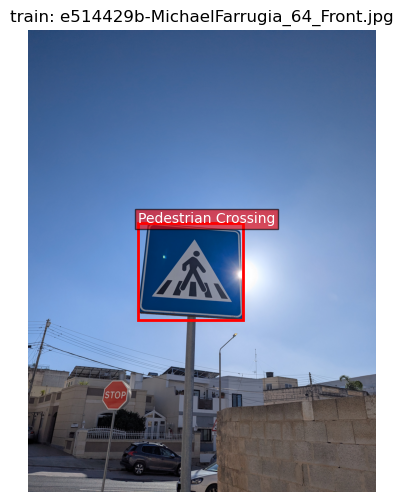

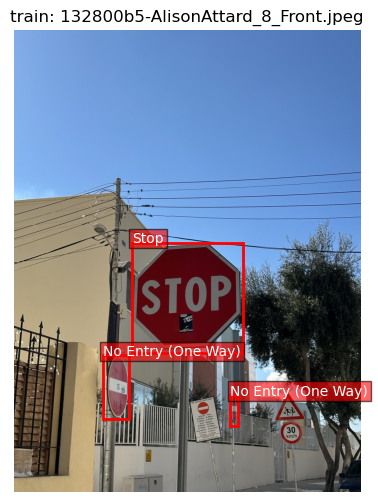

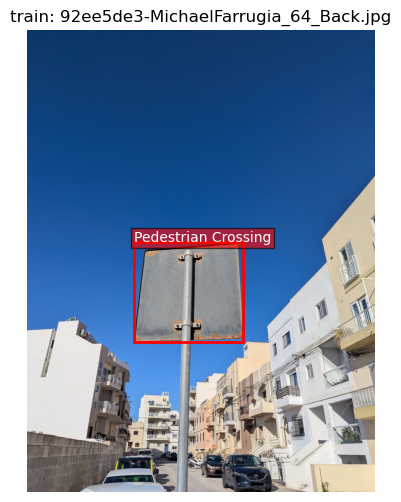

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def load_image(path: Path):
    import cv2
    img_bgr = cv2.imread(str(path))
    if img_bgr is None:
        return None
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def yolo_to_xyxy(x, y, w, h, W, H):
    cx, cy = x * W, y * H
    bw, bh = w * W, h * H
    x1 = cx - bw / 2
    y1 = cy - bh / 2
    x2 = cx + bw / 2
    y2 = cy + bh / 2
    return x1, y1, x2, y2

def show_random_samples(split="train", n=3, seed=3129):
    rng = np.random.default_rng(seed)
    img_dir, lbl_dir, imgs, lbls, _, _ = split_data[split]
    assert len(imgs) > 0, f"No images found in {split}"

    picks = rng.choice(len(imgs), size=min(n, len(imgs)), replace=False)
    for idx in picks:
        img_path = imgs[idx]
        lbl_path = lbl_dir / f"{img_path.stem}.txt"

        img = load_image(img_path)
        if img is None:
            print("Could not read:", img_path)
            continue

        H, W = img.shape[:2]
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(img)
        ax.set_title(f"{split}: {img_path.name}")

        if lbl_path.exists():
            txt = lbl_path.read_text(encoding="utf-8", errors="ignore").strip()
            if txt:
                for line in txt.splitlines():
                    parts = line.split()
                    cls = int(float(parts[0]))
                    x, y, w, h = map(float, parts[1:])
                    x1, y1, x2, y2 = yolo_to_xyxy(x, y, w, h, W, H)
                    rect = patches.Rectangle(
                        (x1, y1), x2 - x1, y2 - y1,
                        linewidth=2, edgecolor="red", facecolor="none"
                    )
                    ax.add_patch(rect)
                    ax.text(x1, y1, CLASS_NAMES[cls], color="white",
                            bbox=dict(facecolor="red", alpha=0.6, pad=2))
        ax.axis("off")
        plt.show()

show_random_samples("train", n=3, seed=SEED)


In [6]:
import yaml
from pathlib import Path
import yaml


data_yaml_json_path = Path(DATA_YAML_JSON)
data_yaml_path = Path(DATA_YAML)

assert data_yaml_json_path.exists(), f"Missing: {data_yaml_json_path}"

data_json = json.loads(data_yaml_json_path.read_text(encoding="utf-8"))


assert "names" in data_json and len(data_json["names"]) == NUM_CLASSES, "names in json does not match NUM_CLASSES"


with open(data_yaml_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(data_json, f, sort_keys=False)

print("Wrote YAML:", data_yaml_path)
print(data_yaml_path.read_text(encoding="utf-8")[:400])


Wrote YAML: dataset\YOLO_COCO\data.yaml
path: dataset/YOLO_COCO/
train: images/train
val: images/val
test: images/test
names:
- Blind-Spot Mirror (Convex)
- No Entry (One Way)
- No Through Road (T-Sign)
- Pedestrian Crossing
- Roundabout Ahead
- Stop



In [7]:
device = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", device)

MODEL_WEIGHTS = "yolov8n.pt"

model = YOLO(MODEL_WEIGHTS)
print("Loaded:", MODEL_WEIGHTS)

Using device: cpu
Loaded: yolov8n.pt


In [8]:
train_results = model.train(
    data=str(Path(DATA_YAML)),   
    epochs=EPOCHS,
    patience=3,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    lr0=LEARNING_RATE,
    seed=SEED,
    device=device,

    project=str((REPO_ROOT / "work_dirs").resolve()),
    name="yolov8_sign_type",
    exist_ok=True,

    mosaic=0.5,
    mixup=0.0,
    copy_paste=0.0,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    fliplr=0.5,
    flipud=0.0,

    hsv_h=0.015,
    hsv_s=0.4,
    hsv_v=0.4,


    deterministic=True,
)

print("Training done.")
print("Save dir:", train_results.save_dir if hasattr(train_results, "save_dir") else "See work_dirs/yolov8_sign_type")


Ultralytics 8.4.9  Python-3.10.19 torch-2.4.1 CPU (12th Gen Intel Core i7-1255U)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset\YOLO_COCO\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=15, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.5, multi_scale=0.0, name=yolov8_sign_type, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=3, perspec

In [9]:
def print_det_metrics(tag, metrics_obj):
    box = getattr(metrics_obj, "box", None)
    if box is None:
        print(f"{tag}: metrics object has no .box attribute, available:", dir(metrics_obj)[:30])
        return

    mAP = getattr(box, "map", None)      
    mAP50 = getattr(box, "map50", None)  
    mAP75 = getattr(box, "map75", None)  
    maps = getattr(box, "maps", None)    

    print(f"\n=== {tag} ===")
    print("mAP   :", mAP)
    print("AP50  :", mAP50)
    print("AP75  :", mAP75)

    if maps is not None and len(maps) == NUM_CLASSES:
        print("\nPer-class AP:")
        for name, ap in zip(CLASS_NAMES, maps):
            print(f"  {name:30s} {ap:.4f}")

val_metrics = model.val(data=str(Path(DATA_YAML)), split="val", imgsz=IMAGE_SIZE, batch=BATCH_SIZE, device=device)
test_metrics = model.val(data=str(Path(DATA_YAML)), split="test", imgsz=IMAGE_SIZE, batch=BATCH_SIZE, device=device)

print_det_metrics("VAL", val_metrics)
print_det_metrics("TEST", test_metrics)


Ultralytics 8.4.9  Python-3.10.19 torch-2.4.1 CPU (12th Gen Intel Core i7-1255U)
Model summary (fused): 73 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 1324.0205.1 MB/s, size: 6297.6 KB)
val: Scanning C:\ARI3129-repo\dataset\YOLO_COCO\labels\val.cache... 88 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 88/88  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 3.5s/it 20.9s4.3ss
                   all         88         92      0.925      0.882      0.952      0.865
Blind-Spot Mirror (Convex)         15         15          1      0.915      0.991      0.871
    No Entry (One Way)         33         33      0.973      0.879      0.938      0.845
No Through Road (T-Sign)         14         14      0.844      0.929      0.963      0.879
   Pedestrian Crossing          9          9      0.821      0.778      0.934      0.828
      Roundabout Ahead          5      

['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


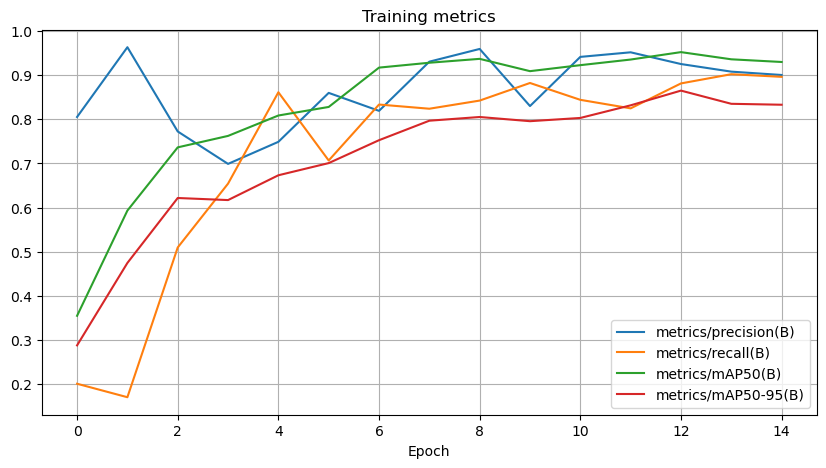

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

run_dir = REPO_ROOT / "work_dirs" / "yolov8_sign_type"

results_csv = run_dir / "results.csv"

assert results_csv.exists(), f"results.csv not found at: {results_csv}"

df = pd.read_csv(results_csv)
print(df.columns.tolist())

cols_to_plot = [c for c in df.columns if "metrics/mAP" in c or "metrics/precision" in c or "metrics/recall" in c]

plt.figure(figsize=(10,5))
for c in cols_to_plot:
    plt.plot(df[c], label=c)
plt.title("Training metrics")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()


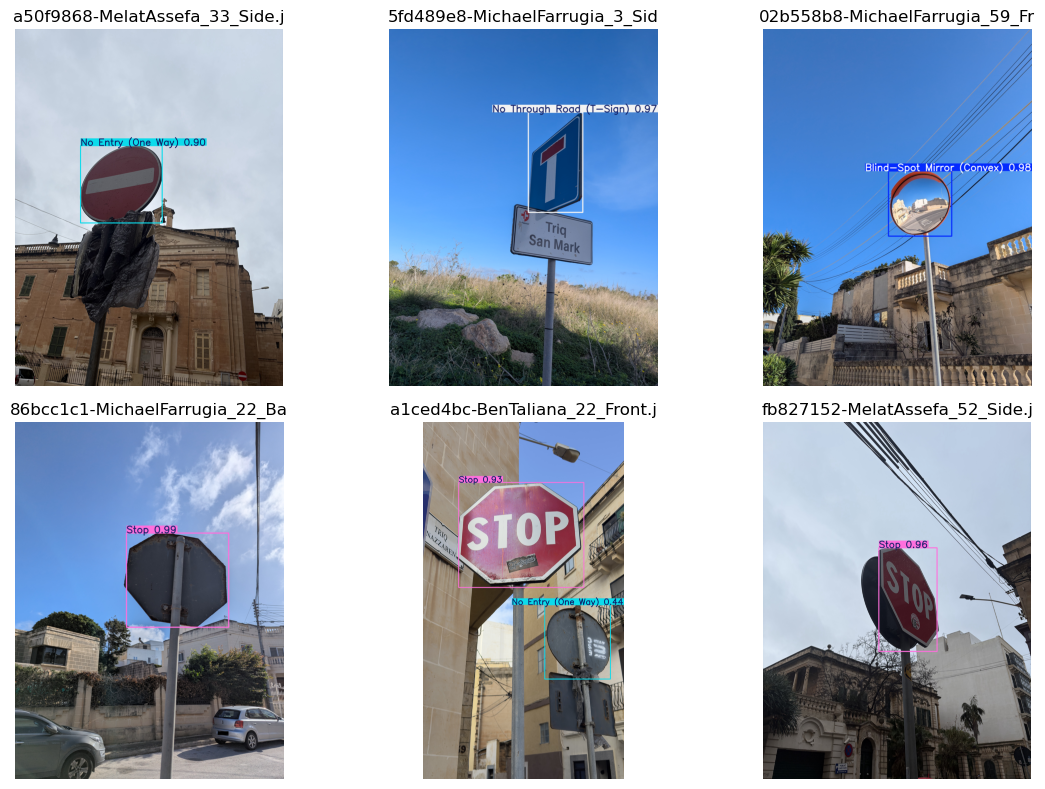

In [11]:
import matplotlib.pyplot as plt
import cv2
import random

test_img_dir = DATA_DIR / "images" / "test"
test_imgs = list_images(test_img_dir)
sample = random.sample(test_imgs, k=min(6, len(test_imgs)))

preds = model.predict([str(p) for p in sample], imgsz=IMAGE_SIZE, conf=0.25, device=device, verbose=False)

plt.figure(figsize=(12,8))
for i, r in enumerate(preds, 1):
    bgr = r.plot()
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i)
    plt.imshow(rgb)
    plt.axis("off")
    plt.title(Path(r.path).name[:30])
plt.tight_layout()
plt.show()


Images sampled: 86
Avg detections/image: 0.9767441860465116
Median detections/image: 1.0
Total detections: 84
Mean confidence: 0.8180528882713545


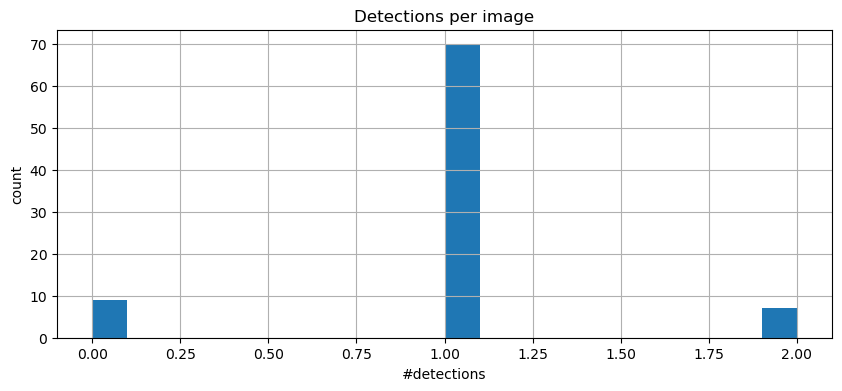

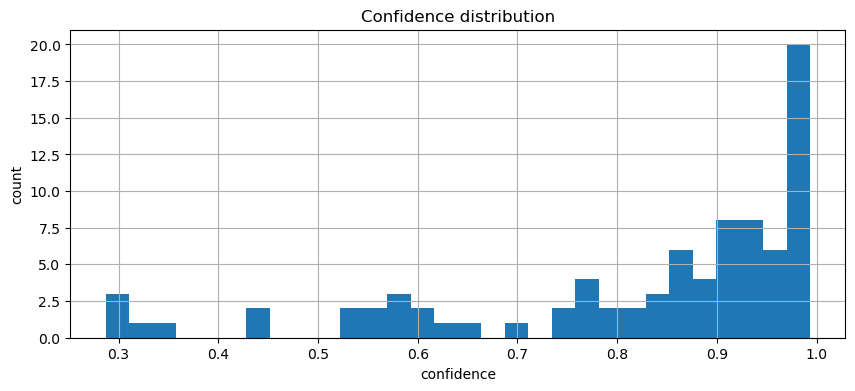

In [12]:
import numpy as np

sample_n = min(120, len(test_imgs))
subset = random.sample(test_imgs, k=sample_n)

all_num_det = []
all_conf = []

preds = model.predict([str(p) for p in subset], imgsz=IMAGE_SIZE, conf=0.25, device=device, verbose=False)

for r in preds:
    boxes = r.boxes
    if boxes is None or len(boxes) == 0:
        all_num_det.append(0)
        continue
    all_num_det.append(len(boxes))
    confs = boxes.conf.detach().cpu().numpy()
    all_conf.extend(confs.tolist())

print("Images sampled:", sample_n)
print("Avg detections/image:", np.mean(all_num_det))
print("Median detections/image:", np.median(all_num_det))
print("Total detections:", len(all_conf))
print("Mean confidence:", np.mean(all_conf) if len(all_conf) else None)

plt.figure(figsize=(10,4))
plt.hist(all_num_det, bins=20)
plt.title("Detections per image")
plt.xlabel("#detections")
plt.ylabel("count")
plt.grid(True)
plt.show()

if len(all_conf):
    plt.figure(figsize=(10,4))
    plt.hist(all_conf, bins=30)
    plt.title("Confidence distribution")
    plt.xlabel("confidence")
    plt.ylabel("count")
    plt.grid(True)
    plt.show()


In [13]:
import time
import numpy as np

# Use a small subset for speed test
speed_imgs = random.sample(test_imgs, k=min(100, len(test_imgs)))

# Warmup
_ = model.predict(str(speed_imgs[0]), imgsz=IMAGE_SIZE, conf=0.25, device=device, verbose=False)

times = []
for p in speed_imgs:
    t0 = time.perf_counter()
    _ = model.predict(str(p), imgsz=IMAGE_SIZE, conf=0.25, device=device, verbose=False)
    t1 = time.perf_counter()
    times.append(t1 - t0)

mean_s = float(np.mean(times))
std_s  = float(np.std(times))
fps = 1.0 / mean_s if mean_s > 0 else None

speed_results = {
    "mean_latency_ms": mean_s * 1000,
    "std_latency_ms": std_s * 1000,
    "FPS": fps
}

print(speed_results)


{'mean_latency_ms': 341.8805174420244, 'std_latency_ms': 119.93926859302195, 'FPS': 2.924998497960851}


In [14]:
import json
import os


best_ckpt = run_dir / "weights" / "best.pt"
last_ckpt = run_dir / "weights" / "last.pt"


best_size_mb = best_ckpt.stat().st_size / (1024 * 1024) if best_ckpt.exists() else None


def metrics_to_dict(metrics_obj):
    box = getattr(metrics_obj, "box", None)
    if box is None:
        return {}
    out = {
        "mAP": float(getattr(box, "map", np.nan)),
        "AP50": float(getattr(box, "map50", np.nan)),
        "AP75": float(getattr(box, "map75", np.nan)),
    }
    maps = getattr(box, "maps", None)
    if maps is not None and len(maps) == NUM_CLASSES:
        out["per_class_AP"] = {name: float(ap) for name, ap in zip(CLASS_NAMES, maps)}
    return out

results_export = {
    "student": "MelatAssefa",
    "model_name": "yolov8",
    "task": "sign_type",
    "framework": "ultralytics",
    "framework_version": getattr(__import__("ultralytics"), "__version__", "unknown"),

    "dataset": {
        "name": "MTSD",
        "num_classes": NUM_CLASSES,
        "class_names": CLASS_NAMES,
        "train_images": len(list_images(DATA_DIR/"images/train")),
        "val_images": len(list_images(DATA_DIR/"images/val")),
        "test_images": len(list_images(DATA_DIR/"images/test")),
    },

    "training": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "image_size": f"{IMAGE_SIZE}x{IMAGE_SIZE}",
        "augmentation": "HSV only (mild). No geometric (mosaic/mixup/flip/scale/rotate disabled).",
        "pretrained": MODEL_WEIGHTS,
        "seed": SEED,
        
    },

    "metrics": metrics_to_dict(test_metrics),

    "model_complexity": {
        "checkpoint_best_size_mb": round(best_size_mb, 2) if best_size_mb is not None else None
    },

    "speed": {
        "device": str(device),
        "batch_size": 1,
        "num_samples": len(speed_imgs),
        "mean_latency_ms": round(speed_results["mean_latency_ms"], 2),
        "std_latency_ms": round(speed_results["std_latency_ms"], 2),
        "FPS": round(speed_results["FPS"], 2) if speed_results["FPS"] is not None else None,
        "includes_preprocessing": True
    },

    "artifacts": {
        "work_dir": str(run_dir),
        "checkpoint_best": str(best_ckpt),
        "checkpoint_last": str(last_ckpt),
        "plots": {
            "training_curves": None,
            "qualitative_grid": None,
            "confidence_histogram": None
        }
    }
}

export_path = run_dir / "results_export.json"
with open(export_path, "w", encoding="utf-8") as f:
    json.dump(results_export, f, indent=2)

print(" Results exported to:", export_path)
print("\nEXPORT SUMMARY:")
print("Student:", results_export["student"])
print("Model:", results_export["model_name"])
print("Test mAP:", results_export["metrics"].get("mAP"))
print("Speed FPS:", results_export["speed"].get("FPS"))


 Results exported to: c:\ARI3129-repo\work_dirs\yolov8_sign_type\results_export.json

EXPORT SUMMARY:
Student: MelatAssefa
Model: yolov8
Test mAP: 0.8266229304339976
Speed FPS: 2.92
